In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
#%matplotlib qt

In [3]:
N = 100
epsilon = 1
sigma = 1
m = 1
v_0 = np.sqrt(2*epsilon/m)
t_0 = sigma * np.sqrt(m/(2*epsilon))
timestep = 3000
delta_t = 0.00005*t_0

## large particle 
M = m * 40
rho = 10

l_space = np.array([sigma*100,sigma*100])
r_particle = np.zeros([N,2],dtype=np.float64)
v_particle = np.ones([N,2])

large_r_particle = np.array([random.uniform(0+rho,l_space[0]-rho),random.uniform(0+rho,l_space[1]-rho)])
large_v_particle = np.array([0,0])
large_particle_path = np.zeros([timestep,2])

energy = np.zeros(timestep)
kinetic_energy = np.zeros(timestep)
potential_energy = np.zeros(timestep)

In [4]:
def initialize_position(r_particle,l_space,sigma,large_r_particle,rho):

    ## initiate position 
    for idx_i,i in enumerate(r_particle):

        all_position_ok = False ## not closer than sigma

        while all_position_ok == False:

            ## random initialize
            position_x = random.uniform(0,l_space[0])
            position_y = random.uniform(0,l_space[1])
            position_new = np.array([position_x,position_y])
            
            ## calculate distance between each particle
            position_ok = True
            for idx_j,j in enumerate(r_particle):
                if idx_i != idx_j :
                    dist = np.linalg.norm(position_new - j)
                    if dist <= 2*sigma:
                        position_ok = False
                        break
            
            ## check with the large particle
            dist = np.linalg.norm(position_new - large_r_particle)
            if dist <= sigma + rho:
                position_ok = False
            
            ## All check clear assign new position
            if position_ok :          
                r_particle[idx_i] = position_new
                all_position_ok = True
            
    return r_particle
            
        

In [5]:
def initialize_velocity(v_particle,v_0):
    
    for idx_i,i in enumerate(v_particle):
        
        velocity_x = random.uniform(-20*v_0,20*v_0)
        ## first term for randomly generate -1 or 1 | second term for calculating euclidean distance
        velocity_y = (random.randint(0,1)*2-1) * np.sqrt((20*v_0)**2 - (velocity_x**2))
        velocity_new = np.array([velocity_x,velocity_y])

        v_particle[idx_i] = velocity_new
    
    return v_particle


In [6]:
def calculate_force(i,j,epsilon,sigma):
    r_ij = np.linalg.norm(i - j)
    r_ij_x = i[0] - j[0]
    r_ij_y = i[1] - j[1]
    f = epsilon * ( (48*(sigma**12)/(r_ij**13)) - 24*(sigma**6)/(r_ij**7))
    return np.array([f*r_ij_x/r_ij,f*r_ij_y/r_ij])


In [7]:
def calculate_force_large(i,j,epsilon,sigma,rho):
    r_ij = np.linalg.norm(i - j) - rho
    r_ij_x = abs(i[0] - j[0]) - rho
    r_ij_y = abs(i[1] - j[1]) - rho
    f = epsilon * ( (48*(sigma**12)/(r_ij**13)) - 24*(sigma**6)/(r_ij**7))
    return np.array([f*r_ij_x/r_ij,f*r_ij/r_ij_y])


In [8]:
def calculate_potential_energy(i,j,epsilon,sigma,rho):
    r_ij = np.linalg.norm(i - j) - rho
    term_1 = (sigma/r_ij)**12
    term_2 = (sigma/r_ij)**6
    e = 4 * epsilon * (term_1 - term_2)
    return e

In [9]:
def plot_large_particle_path(large_particle_path,large_r_particle,r_particle,timestep,l_space):
    plt.clf()
    plt.axis([0,l_space[0],0,l_space[1]])
    plt.ylabel('$y$')
    plt.xlabel('$x$')
    plt.scatter(large_r_particle[0],large_r_particle[1],s=rho**2)
    plt.scatter(r_particle[:,0],r_particle[:,1],s=1)
    for t in range(timestep):
        plt.scatter(large_particle_path[t,0],large_particle_path[t,1],s=1,color="red")  

In [ ]:
r_particle = initialize_position(r_particle,l_space,sigma,large_r_particle,rho)
v_particle = initialize_velocity(v_particle,v_0)

for t in range(timestep):
    
    total_potential_energy = 0
    total_kinetic_energy = 0
    large_particle_path[t] = large_r_particle

    ################## SMALL PARTICLE ########################

    ## force reaction to each other
    for idx_i,i in enumerate(r_particle):

        total_force = np.zeros(2)

        for idx_j,j in enumerate(r_particle):
            if idx_i!=idx_j:
                f = calculate_force(i,j,epsilon,sigma)
                total_force = total_force + f
                total_potential_energy += 0.5*calculate_potential_energy(i,j,epsilon,sigma,0)

        ## large particle force
        large_force = calculate_force_large(i,large_r_particle,epsilon,sigma,rho)
        total_force = total_force + large_force
        total_potential_energy += calculate_potential_energy(i,j,epsilon,sigma,rho)
                
        ## leap frog algorithm
        
        r_half = r_particle[idx_i] + (v_particle[idx_i] * delta_t / 2)
        v_next = v_particle[idx_i] + (total_force / m * delta_t)
        r_next = r_half + (v_next * delta_t / 2)

        ## check boundary
        if r_next[0] > l_space[0] or r_next[0] < 0:
            v_next[0] = -v_next[0]
    
        if r_next[1] > l_space[1] or r_next[1] < 0:
            v_next[1] = -v_next[1]
        r_next = r_half + (v_next * delta_t / 2)

        r_particle[idx_i] = r_next
        v_particle[idx_i] = v_next

        velocity = np.sqrt(v_particle[idx_i][0]**2 + v_particle[idx_i][1]**2)
        K = 0.5 * m * (velocity**2)
        total_kinetic_energy += K

    ################## SMALL PARTICLE ########################


    ################## LARGE PARTICLE ########################

    total_force = np.zeros(2)
    for idx_j,j in enumerate(r_particle):
        large_force = calculate_force_large(j,large_r_particle,epsilon,sigma,rho)
        total_force = total_force + large_force
    
    ## leap frog algorithm
        
    r_half = large_r_particle + (large_v_particle * delta_t / 2)
    v_next = large_v_particle + (total_force / M * delta_t)
    r_next = r_half + (v_next * delta_t / 2)

    ## check boundary
    if r_next[0] > l_space[0]-rho or r_next[0]+rho < 0:
        v_next[0] = -v_next[0]
    
    if r_next[1] > l_space[1]-rho or r_next[1]+rho < 0:
        v_next[1] = -v_next[1]
    r_next = r_half + (v_next * delta_t / 2)

    large_r_particle = r_next
    large_v_particle = v_next

    velocity = np.sqrt(large_v_particle[0]**2 + large_v_particle[1]**2)
    K = 0.5 * m * (velocity**2)
    total_kinetic_energy += K

    ################## LARGE PARTICLE ########################

    total_energy = total_kinetic_energy + total_potential_energy

    energy[t] = total_energy
    potential_energy[t] = total_potential_energy
    kinetic_energy[t] = total_kinetic_energy
    # print(t)
    plt.clf()
    plt.title(t)
    plt.axis([0,l_space[0],0,l_space[1]])
    plt.scatter(large_r_particle[0],large_r_particle[1],s=rho**2)
    plt.scatter(r_particle[:,0],r_particle[:,1],s=1)
    plt.scatter(large_particle_path[:,0],large_particle_path[:,1],s=1)
    plt.show(block=False)
    plt.pause(0.0001)


## 1.8 a)

N = 36
timestep = 1000

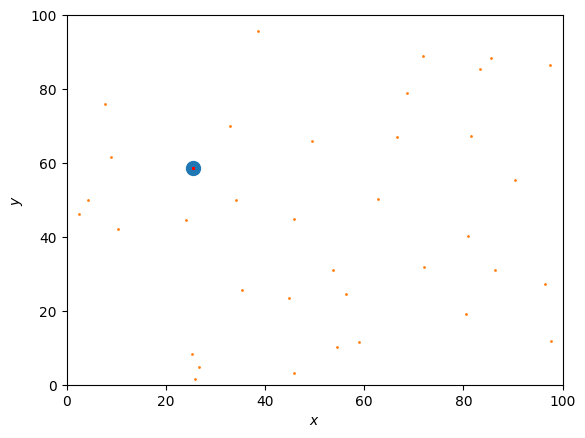

In [107]:
large_r_particle_a = large_r_particle
r_particle_a = r_particle
large_particle_path_a = large_particle_path

plot_large_particle_path(large_particle_path_a,large_r_particle_a,r_particle_a,timestep,l_space)

## 1.8 b)

N = 100
timestep = 3000

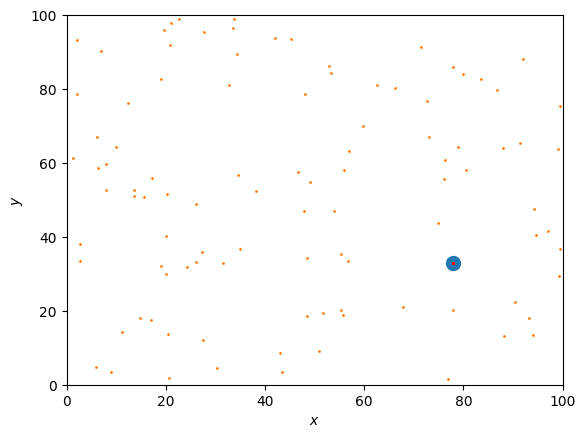

In [11]:
large_r_particle_b = large_r_particle
r_particle_b = r_particle
large_particle_path_b = large_particle_path

plot_large_particle_path(large_particle_path_b,large_r_particle_b,r_particle_b,timestep,l_space)

In [12]:
r_diff = 0
for i in range(1,timestep-2):
    x_diff = large_particle_path[i+1][0] - large_particle_path[i][0]
    y_diff = large_particle_path[i+1][1] - large_particle_path[i][1]
    r_diff += x_diff**2 + y_diff**2
msd = (1/(timestep - 1)) * r_diff
print("MSD : "+ str(msd))

MSD : 1.3167265708910084e-15
